In [ ]:
import torch

import deepinv as dinv
import matplotlib.pyplot as plt

from data import get_dataset
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.img_utils import clear_color
from util.plot_utils import show_reconstruction, confidence_interval

from tasks import create_operator
from gibbs_sampler import GibbsSampler
from sample_dncnn.sampler_dncnn import create_sampler_dn


In [18]:
# Check device
device_str = "cuda:" if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

In [19]:
# Here, we will focus on gaussian blur operator
operator_config = {
    "name": "gaussian_blur",
    "kernel_size": 61,
    "intensity": 3.0,
    "channels": 3,
    "img_dim": 128
}

# Create the linear operator
H_gaussian = create_operator(**operator_config, device=device)


In [20]:
# Get the test dataset
dsize = (128,128)
dataset_ffhq = get_dataset("ffhq", root="data/samples_ffhq", dsize=dsize)
dataset_celeba = get_dataset("celeba", root="data/samples_celeba", dsize=dsize)
dataset_mri = get_dataset("mri", root="data/samples_mri", dsize=dsize)

sample_ffhq = dataset_ffhq[0]
sample_celeba = dataset_celeba[0]
sample_mri = dataset_mri[0]


In [21]:
sample_ffhq.shape

torch.Size([3, 128, 128])

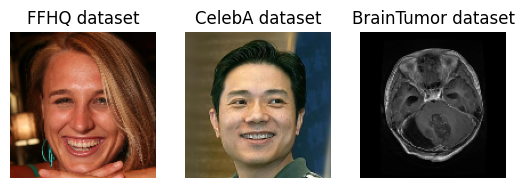

In [22]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(clear_color(sample_ffhq))
axes[0].set_title('FFHQ dataset')
axes[0].set_axis_off()

axes[1].imshow(clear_color(sample_celeba))
axes[1].set_title('CelebA dataset')
axes[1].set_axis_off()

axes[2].imshow(clear_color(sample_mri))
axes[2].set_title('BrainTumor dataset')
axes[2].set_axis_off()

plt.show()


## With DnCNN model as a denoiser

In [23]:
# Download pretrained DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
model = dinv.models.DnCNN(pretrained='download').to(device)
# model = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_lipschitz_color.pth').to(device)

In [27]:
# Select configurations for the sampler in the case of diffusion
sampler_config = {
    "tau": 0.005,
    "nu": 0.05,
    "s": 0.1
}
# Create sampler to be used in the case of diffusion
diffusion_sampler = create_sampler_dn(**sampler_config)

In [25]:
diffusion_sampler

## Sample

In here, we use the fact that we divide our problem in (1) sampling x such that x is close to z and (2) sampling z as a denoised image

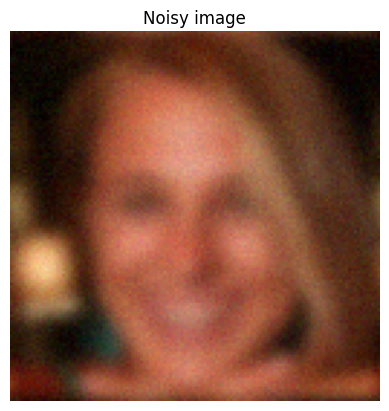

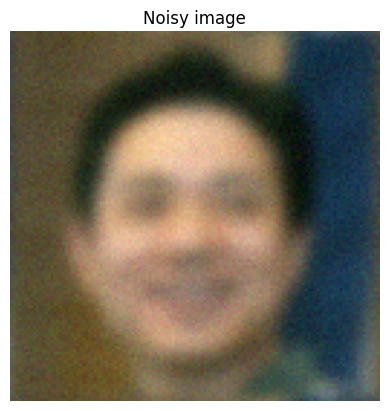

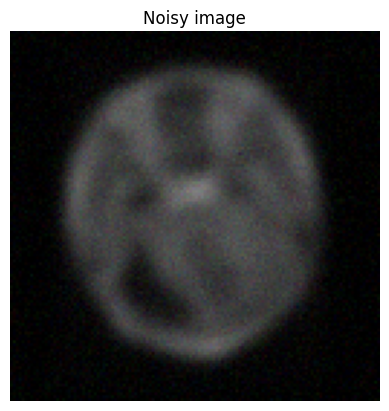

In [28]:
# Lets see with just one test sample
X = {'ffhq': sample_ffhq, 'celeba': sample_celeba, 'mri': sample_mri}
Y = {}
sigma = torch.tensor(sampler_config['nu']).to(device)

for name in X.keys():
    x = X[name]
    y = H_gaussian.forward(x)
    # Creating the noisy image Y = HX + n
    y = y + sigma*torch.randn(x.shape).to(device)
    Y[name] = y
    # Plot noisy image
    fig, ax = plt.subplots()
    ax.imshow(clear_color(y))
    ax.set_title('Noisy image')
    ax.axis('off')
    plt.savefig(f"results/image_{name}_noisy.png", dpi=200, bbox_inches='tight')

    plt.show()


In [ ]:
# Execute sampling
# N_bi : number of burn-in iterations
# N_MC : number of total iterations
def execute_sampling(noisy_img, model, sampler, model_type, name, N_bi = 20, N_MC = 25):

    # Set initial noisy image to the sampler
    if model_type == 'DnCNN':
        sampler.set_y(noisy_img)

    # Define gibbs configurations
    gibbs = GibbsSampler(
                         Y=noisy_img,
                         sigma=sigma,
                         operator=H_gaussian,
                         sampler=sampler,
                         model=model,
                         model_type=model_type,
                         device=device,
                         N_MC=23,
                         N_bi=20,
                         # Not used when model_type is 'DnCNN'
                         rho=0.1,
                         rho_decay_rate=0.8,
                         plot_process = 5)

    X_MC, Z_MC = gibbs.run()

    X_mean = torch.mean(X_MC[:,:,:,N_bi:N_MC], axis=-1)
    Z_mean = torch.mean(Z_MC[:,:,:,N_bi:N_MC], axis=-1)

    # Plot reconstructed X and Z
    show_reconstruction(Z_mean, X_mean , 'final')

    # Confidence intervals
    confidence_interval(X_MC[:,:,:,N_bi:N_MC])


## Comparing with the output after one diffusion step back

Here, we are estimating the noise level of the original image Y, and then passing it to backward diffusion to recover an estimative of X